In [1]:
!pip install --upgrade setuptools 
!pip install --upgrade Pandas
!pip install --upgrade openpyxl 
!pip install --upgrade scikit-learn
!pip install --upgrade pyspark
!pip install --upgrade seaborn

In [2]:
import seaborn as sns
import pandas as pd
from pyspark.sql import SparkSession
import pyspark.sql.functions as f

In [3]:
spark = SparkSession.builder.appName("spark_ok").getOrCreate()

<h3> Visualização dos dados: </h3>

In [4]:
id_df = r'C:\Users\nicol\OneDrive\Documents\Visual Studio - 2024\Estudos\Analise Descritiva - Churn\train.csv'

In [5]:
df_clientes_sujo = spark.read.csv(id_df, header=True, inferSchema=True)

In [6]:
df_clientes_sujo.show(10)

+-----+--------------+-------------+------------------+---------------+---------------------+-----------------+---------------+----------------+-----------------+---------------+----------------+-------------------+-----------------+------------------+------------------+----------------+-----------------+-----------------------------+-----+
|state|account_length|    area_code|international_plan|voice_mail_plan|number_vmail_messages|total_day_minutes|total_day_calls|total_day_charge|total_eve_minutes|total_eve_calls|total_eve_charge|total_night_minutes|total_night_calls|total_night_charge|total_intl_minutes|total_intl_calls|total_intl_charge|number_customer_service_calls|churn|
+-----+--------------+-------------+------------------+---------------+---------------------+-----------------+---------------+----------------+-----------------+---------------+----------------+-------------------+-----------------+------------------+------------------+----------------+-----------------+--------

<h3> Limpeza dos dataframes e simplificação <h3>

In [7]:
df_clientes = df_clientes_sujo.withColumnRenamed("state", "estado") \
       .withColumnRenamed("account_length", "tempo_conta_meses") \
       .withColumnRenamed("area_code", "codigo_area") \
       .withColumnRenamed("international_plan", "plano_internacional") \
       .withColumnRenamed("voice_mail_plan", "plano_correio_voz") \
       .withColumnRenamed("number_vmail_messages", "num_mensagens_correio_voz") \
       .withColumnRenamed("total_day_minutes", "total_minutos_dia") \
       .withColumnRenamed("total_day_calls", "total_chamadas_dia") \
       .withColumnRenamed("total_day_charge", "total_custo_dia") \
       .withColumnRenamed("total_eve_minutes", "total_minutos_tarde") \
       .withColumnRenamed("total_eve_calls", "total_chamadas_tarde") \
       .withColumnRenamed("total_eve_charge", "total_custo_tarde") \
       .withColumnRenamed("total_night_minutes", "total_minutos_noite") \
       .withColumnRenamed("total_night_calls", "total_chamadas_noite") \
       .withColumnRenamed("total_night_charge", "total_custo_noite") \
       .withColumnRenamed("total_intl_minutes", "total_minutos_internacionais") \
       .withColumnRenamed("total_intl_calls", "total_chamadas_internacionais") \
       .withColumnRenamed("total_intl_charge", "total_custo_internacionais") \
       .withColumnRenamed("number_customer_service_calls", "num_chamadas_atendimento_cliente") \
       .withColumnRenamed("churn", "churn")

In [8]:
df_clientes = df_clientes.withColumn('fl_churn', 
                            f.when(f.col('churn') == 'yes', 1)
                            .otherwise(0)
       ).withColumn('fl_plano_internacional',
                            f.when(f.col('plano_internacional') == 'yes', 1)
                            .otherwise(0)
       ).withColumn('fl_plano_correio_voz', 
                            f.when(f.col('plano_correio_voz') == 'yes', 1)
                            .otherwise(0)
       ).drop('churn', 'plano_internacional', 'plano_correio_voz')

In [9]:
df_clientes.printSchema()

root
 |-- estado: string (nullable = true)
 |-- tempo_conta_meses: integer (nullable = true)
 |-- codigo_area: string (nullable = true)
 |-- num_mensagens_correio_voz: integer (nullable = true)
 |-- total_minutos_dia: double (nullable = true)
 |-- total_chamadas_dia: integer (nullable = true)
 |-- total_custo_dia: double (nullable = true)
 |-- total_minutos_tarde: double (nullable = true)
 |-- total_chamadas_tarde: integer (nullable = true)
 |-- total_custo_tarde: double (nullable = true)
 |-- total_minutos_noite: double (nullable = true)
 |-- total_chamadas_noite: integer (nullable = true)
 |-- total_custo_noite: double (nullable = true)
 |-- total_minutos_internacionais: double (nullable = true)
 |-- total_chamadas_internacionais: integer (nullable = true)
 |-- total_custo_internacionais: double (nullable = true)
 |-- num_chamadas_atendimento_cliente: integer (nullable = true)
 |-- fl_churn: integer (nullable = false)
 |-- fl_plano_internacional: integer (nullable = false)
 |-- fl_pl

In [10]:
!pip install --upgrade matplotlib

<h3> Analise Descritivia </h3>

In [11]:
df_pandas = df_clientes.toPandas()

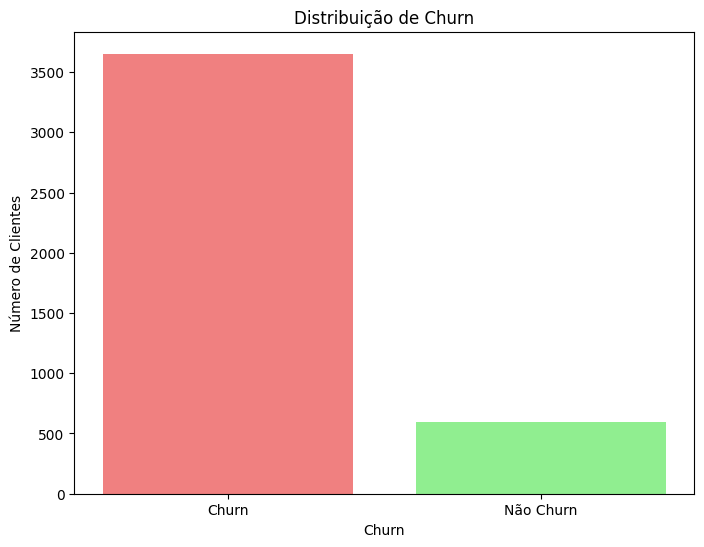

In [12]:
import matplotlib.pyplot as plt

churn_counts = df_pandas['fl_churn'].value_counts()

# Criando um gráfico de barras empilhadas #
plt.figure(figsize=(8, 6))
sns.set_palette("Set2")  # Definindo a paleta de cores

# Plota o gráfico #
plt.bar(churn_counts.index, churn_counts, color=['lightcoral', 'lightgreen'])

# Adiciona rótulos e título #
plt.title("Distribuição de Churn")
plt.xlabel("Churn")
plt.ylabel("Número de Clientes")
plt.xticks(churn_counts.index, ['Churn', 'Não Churn'])

# Exibe o gráfico #
plt.show()

<h3> Somar colunas para facilitar na analise </h3>

In [13]:
df_clientes = df_clientes.withColumn('total_minutos_24h', 
                               f.col('total_minutos_dia') + f.col('total_minutos_tarde') + f.col('total_minutos_noite') + f.col('total_minutos_internacionais') # total minutos mes
                ).withColumn('total_chamadas_24h', 
                            f.col('total_chamadas_dia') + f.col('total_chamadas_tarde') + f.col('total_chamadas_noite') + f.col('total_chamadas_internacionais') # total chamadas mes
                ).withColumn('total_custo_24h',
                            f.col('total_custo_dia') + f.col('total_custo_tarde') + f.col('total_custo_noite') + f.col('total_custo_internacionais') # total custo mes 
                            
                )

dropar_desnecessarias = [
    'total_minutos_dia', 'total_minutos_tarde', 'total_minutos_noite', 'total_minutos_internacionais',
    'total_chamadas_dia', 'total_chamadas_tarde', 'total_chamadas_noite', 'total_chamadas_internacionais',
    'total_custo_dia', 'total_custo_tarde', 'total_custo_noite', 'total_custo_internacionais'
]

df_clientes_reduzido = df_clientes.drop(*dropar_desnecessarias)

df_clientes_reduzido = df_clientes_reduzido.withColumn('total_minutos_24h', f.col('total_minutos_24h').cast('decimal(10,2)')
                ).withColumn('total_custo_24h',  f.col('total_custo_24h').cast('decimal(10,2)'))


In [14]:
df_clientes_reduzido.printSchema()

root
 |-- estado: string (nullable = true)
 |-- tempo_conta_meses: integer (nullable = true)
 |-- codigo_area: string (nullable = true)
 |-- num_mensagens_correio_voz: integer (nullable = true)
 |-- num_chamadas_atendimento_cliente: integer (nullable = true)
 |-- fl_churn: integer (nullable = false)
 |-- fl_plano_internacional: integer (nullable = false)
 |-- fl_plano_correio_voz: integer (nullable = false)
 |-- total_minutos_24h: decimal(10,2) (nullable = true)
 |-- total_chamadas_24h: integer (nullable = true)
 |-- total_custo_24h: decimal(10,2) (nullable = true)



In [15]:
# existe mais de um codigo_area por estado # 
df_clientes_reduzido.select('estado', 'codigo_area').filter(f.col('estado') == 'KY').distinct().show()

+------+-------------+
|estado|  codigo_area|
+------+-------------+
|    KY|area_code_510|
|    KY|area_code_415|
|    KY|area_code_408|
+------+-------------+



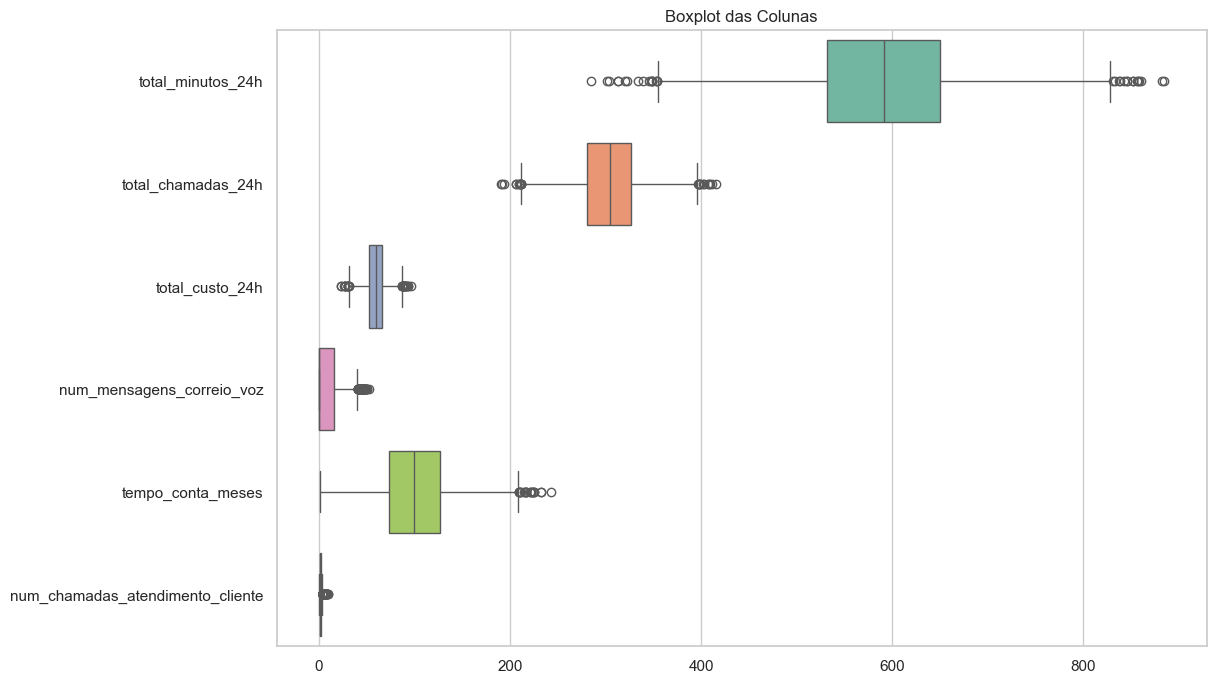

In [95]:
# visualizando a distribuição das variáveis #

colunas = [
    "total_minutos_24h",
    "total_chamadas_24h",
    "total_custo_24h",
    "num_mensagens_correio_voz",
    "tempo_conta_meses",
    "num_chamadas_atendimento_cliente"
    ]

df_colunas = df_clientes_reduzido.select(colunas)

df_pandas_2 = df_colunas.toPandas()

# criando boxplot # 
plt.figure(figsize=(12, 8))
sns.set(style="whitegrid")
sns.boxplot(data=df_pandas_2, orient="h", palette="Set2")
plt.title("Boxplot das Colunas")
plt.show()

In [74]:
# calculando media, mediana, moda, desvio padrao e intervalo para as principais variaveis # 

colunas_estatistica = [
    "total_minutos_24h",
    "total_chamadas_24h",
    "total_custo_24h",
    "num_mensagens_correio_voz",
    "tempo_conta_meses",
    "num_chamadas_atendimento_cliente"
    ]

# o groupby() vazio serve quando você quer calcular a média de todos #
media = df_clientes_reduzido.groupBy(
    "fl_churn",
    "fl_plano_internacional",
    "fl_plano_correio_voz"
    ).agg(
        f.avg("total_minutos_24h").alias("media_total_minutos_24h"),
        f.avg("total_chamadas_24h").alias("media_total_chamadas_24h"),
        f.avg("total_custo_24h").alias("media_total_custo_24h"),
        f.avg("num_mensagens_correio_voz").alias("media_num_mensagens_correio_voz"),
        f.avg("tempo_conta_meses").alias("media_tempo_conta_meses"),
        f.avg("num_chamadas_atendimento_cliente").alias("media_num_chamadas_atendimento_cliente")
        )

# primeiros passos com for # 
# *[] está relacionado com o conceito de desempacotamento em Python
# o método agg em um DataFrame do PySpark, pode esperar que cada expressão seja um argumento separado. 
# Usar * nesse contexto permite que cada expressão gerada na compreensão de lista seja tratada como um argumento distinto para a função agg. 
# cada expressão é passada como um argumento individual, e não como uma lista única.

mediana = df_clientes_reduzido.groupBy(
    "fl_churn",
    "fl_plano_internacional",
    "fl_plano_correio_voz"
    ).agg(
        *[f.expr(f"percentile_approx({col}, 0.5)").alias(f'mediana_{col}') for col in colunas_estatistica] #calcular a media ou o 2º quartil
        )

moda = df_clientes_reduzido.groupBy(
    "fl_churn",
    "fl_plano_internacional",
    "fl_plano_correio_voz"
).agg(
    *[f.expr(f"mode({col})").alias(f"moda_{col}") for col in colunas_estatistica] # mode para calcular moda em sql
        )

desvio_padrao = df_clientes_reduzido.groupBy(
    "fl_churn",
    "fl_plano_internacional",
    "fl_plano_correio_voz"
    ).agg(
    *[f.stddev(col).alias(f"desvio_p_{col}") for col in colunas_estatistica] # stddev calcular desvio padrão em pyspark
        )

intervalo = df_clientes_reduzido.groupBy(
    "fl_churn",
    "fl_plano_internacional",
    "fl_plano_correio_voz"
    ).agg(
        *[(f.max(col) - f.min(col)).alias(f"intervalo_{col}") for col in colunas_estatistica]
            )


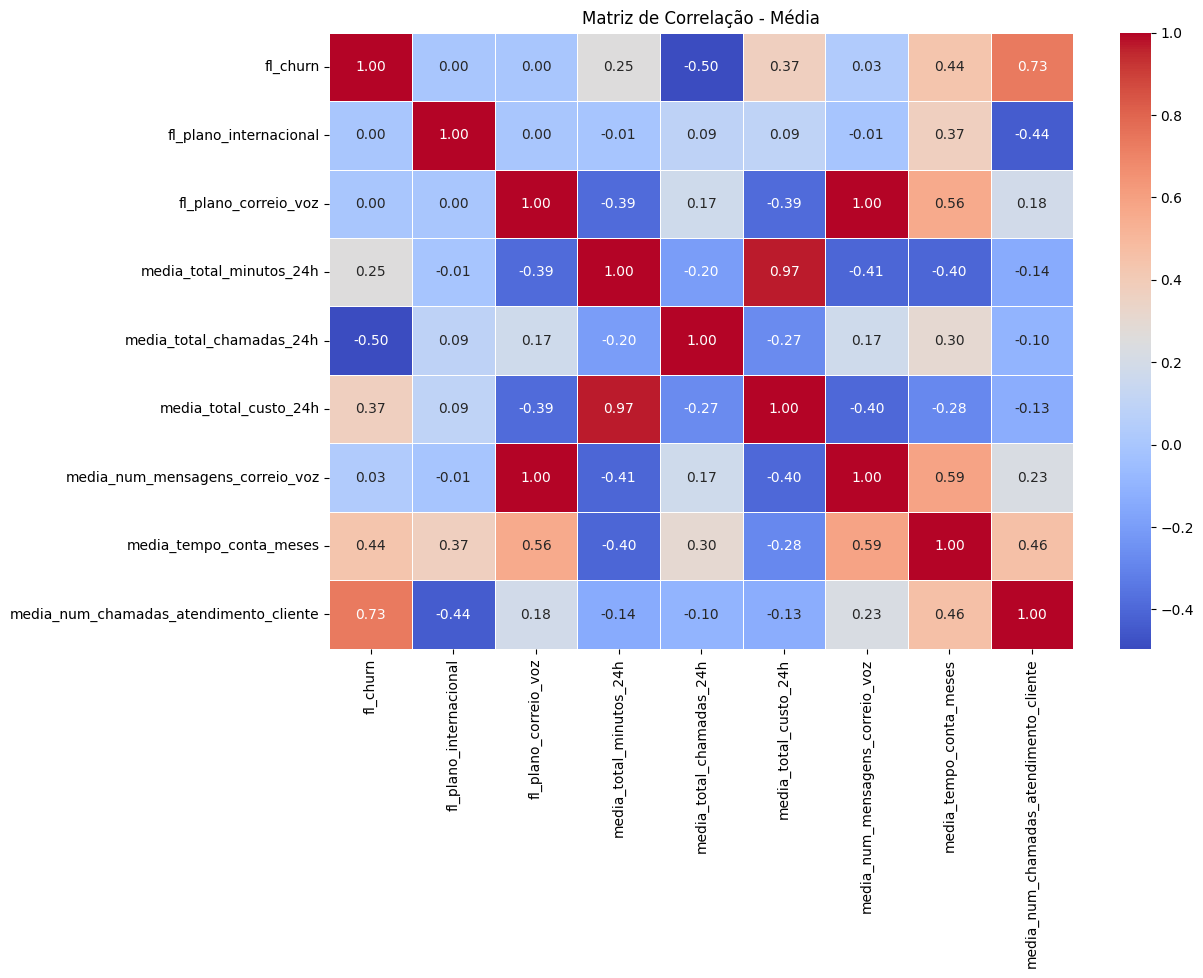

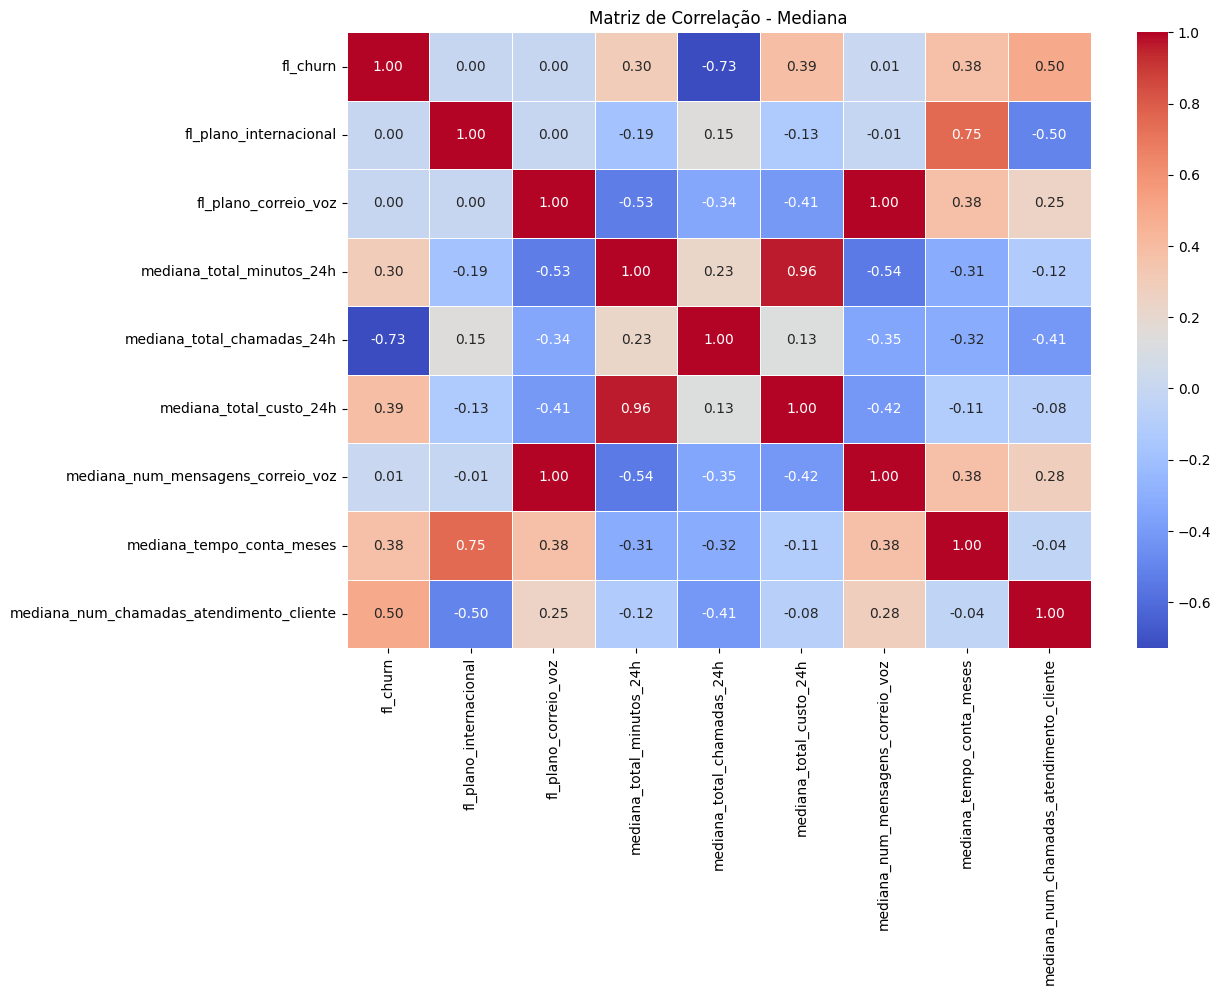

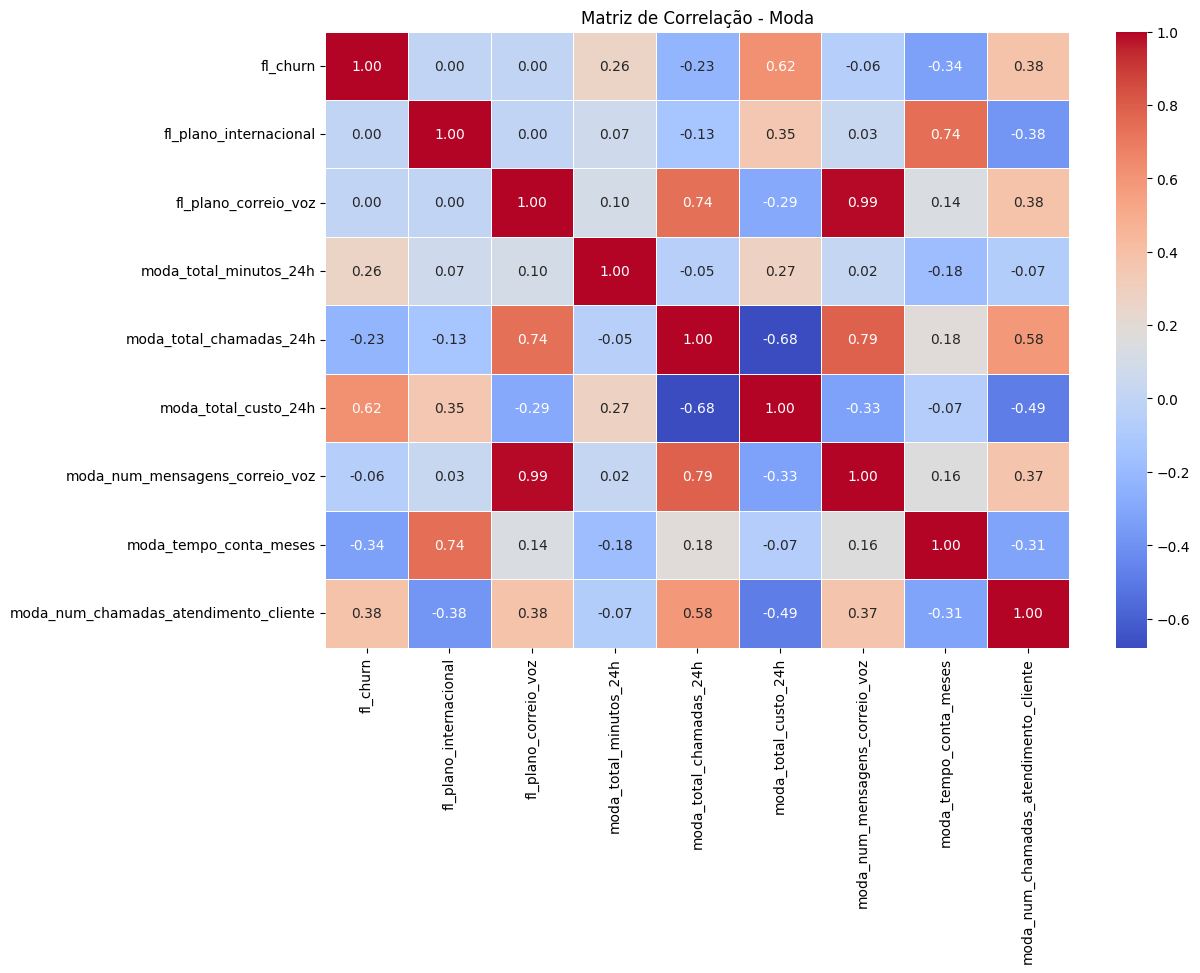

In [79]:
# Função para criar a matriz de correlação #
def create_correlation_matrix(statistic_df, statistic_name):
    # Convertendo as estatísticas para um DataFrame Pandas #
    df_statistic_pandas = statistic_df.toPandas()

    # Criando a matriz de correlação usando seaborn #
    plt.figure(figsize=(12, 8))
    plt.title(f"Matriz de Correlação - {statistic_name}")
    sns.heatmap(df_statistic_pandas.corr(), annot=True, cmap="coolwarm", fmt=".2f", linewidths=.5)
    plt.show()

# Criando e exibindo matrizes de correlação para cada estatística #
create_correlation_matrix(media, "Média")
create_correlation_matrix(mediana, "Mediana")
create_correlation_matrix(moda, "Moda")

In [86]:
# Desvio Padrão: Indica a dispersão dos dados em relação à média. Quanto maior o desvio padrão, maior a variabilidade dos dados # 
desvio_padrao.show()

+--------+----------------------+--------------------+--------------------------+---------------------------+------------------------+----------------------------------+--------------------------+-----------------------------------------+
|fl_churn|fl_plano_internacional|fl_plano_correio_voz|desvio_p_total_minutos_24h|desvio_p_total_chamadas_24h|desvio_p_total_custo_24h|desvio_p_num_mensagens_correio_voz|desvio_p_tempo_conta_meses|desvio_p_num_chamadas_atendimento_cliente|
+--------+----------------------+--------------------+--------------------------+---------------------------+------------------------+----------------------------------+--------------------------+-----------------------------------------+
|       0|                     1|                   1|         98.09561697850407|         34.301899216443886|      10.808454136839241|                  8.80815780355572|         35.62324420866677|                       1.0897603588640727|
|       0|                     0|           

In [87]:
# A diferença entre o valor máximo e mínimo do conjunto de dados # 
intervalo.show()

+--------+----------------------+--------------------+---------------------------+----------------------------+-------------------------+-----------------------------------+---------------------------+------------------------------------------+
|fl_churn|fl_plano_internacional|fl_plano_correio_voz|intervalo_total_minutos_24h|intervalo_total_chamadas_24h|intervalo_total_custo_24h|intervalo_num_mensagens_correio_voz|intervalo_tempo_conta_meses|intervalo_num_chamadas_atendimento_cliente|
+--------+----------------------+--------------------+---------------------------+----------------------------+-------------------------+-----------------------------------+---------------------------+------------------------------------------+
|       0|                     1|                   1|                     414.10|                         154|                    47.29|                                 46|                        150|                                         4|
|       0|          